<a href="https://colab.research.google.com/github/harnalashok/deeplearning-sequences/blob/main/temperature_forecasting_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 01st Feb, 2023
# My folder: /home/ashok/Documents/14.sensor_data
# VM: lubuntu_deeplearning_I.vdi
# Ref: Page 207, Chapter 6, Deep Learning with Python by Fracois Chollete
# Download dataset from:
# 1. Link to my google drive
#  https://drive.google.com/file/d/1rnhlFKmmmhXqawaIBgjSTsqGrTLCUldV/view?usp=sharing
# 2. Link to original datasource
#  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In [ ]:
# Objectives:
#             i)  Working with timeseries data
#             i)  Working with sensor data
#                 (Data comes from many sensors)
#             ii) Processing data to make it fit for modeling
#            iii) Creating a data generator for training and validation
#            iv)  Making predictions using
#                   a) Fully connected dense model
#                   b) GRU model
#                   c) GRU model with dropouts
#                   d) Stacked GRU models
#                   e) Bidirectional RNN layer
#
#

## Task

In [ ]:
# We will predict temperature
# Sensor data is recorded every 10 minutes. So per-day we have:
#   no of minutes:              24 * 60     =  1440
#   no of 10 minutes interval: (24 * 60)/10 = 144 datapoints/per day
#   no of data-points in 10 days: 1440

## Call libraries

In [1]:
# 1.0 Reset all variables
#%reset -f

# 1.0 Call libraries
import numpy as np
import matplotlib.pyplot as plt
import os, time, gc, pathlib

In [2]:
# 1.0.1 Display multiple outputs from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Mount gdrive

In [3]:
# 1.1
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## How to read csv data
`
>open()<br>
>f.read()<br>
>f.close()<br>
>data.split('\n')<br>
>lines.split(',')<br>
`

In [6]:
# 1.1 Where is my data folder?
data_dir = '/gdrive/MyDrive/Colab_data_files/jena'

# 1.1.0 Make data_dir a pathlib object
folderPath = pathlib.Path(data_dir)

In [7]:
# 1.2 Join datapath with filename (intelligently)
#     If you are on Windows, assign to fname full
#     data path+ filename
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
fname

'/gdrive/MyDrive/Colab_data_files/jena/jena_climate_2009_2016.csv'

In [8]:
# 1.2 Get filename
fname = folderPath / 'jena_climate_2009_2016.csv'

In [9]:
# 1.3 Read datafile, line by line
# 1.3.1 First get a handle to file
f = open(fname)   # open() default mode is text+read
# 1.3.2 Use handle to read complete file
data = f.read()

In [10]:
# 1.3.3 Close read file
f.close()

In [ ]:
type(data)

str

## Observe read file data
Basic python operations on file

In [ ]:
# 1.3.4 Check data type
assert type(data) is str
print("\n====\n")
type(data) #  str


====



str

In [ ]:
# 1.3.5 Observe data string

data[0:200]      # Whole data is read as one string
                 # Read first 200 characters of string
                 # Note '\n' at 196th character


'"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"\n01.0'

In [11]:
# 1.4 Look at data
# 1.4.1 Split data on newline (\n). So how many records?
lines = data.split('\n')    # Split data 'str' at every 'newline'
                            # and collect the str(s) in a list
print("\n=====\n")
type(lines)                 # list =>  All splits are in one list
print("\n=====\n")
len(lines)                  # Total splits/elements are 420552
print("\n=====\n")
lines[3]                    # Just print some element of list




=====



list


=====



420552


=====



'01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60'

In [15]:
# 1.4.2 Does any header exist? Check
lines[0]                   # yes, it does
print("\n=====\n")
lines[1]

'"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"'


=====



'01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'

In [ ]:
# 1.4.3.1 Actual data from csv file
#         Note each col-header is a string
#         but each col value is NOT
"""
"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60
"""

In [16]:
# 1.4.3 Extract header (field-names)
header = lines[0].split(',')  # Split at each ','
header  # A list of strs AND within each string is a string

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [17]:
# 1.4.4 How many columns/fields?
cols = len(header)
cols             # 15

15

In [18]:
# 1.4.5 Print first three rows.
#       Note 10-minute gap in the
#       observations
lines[1:4]     # A list of 3 string elements
print("\n======\n")
len(lines)    # 420552 or header + 420551 data points

['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30',
 '01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10',
 '01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60']

420552

In [19]:
# 1.4.6 Total samples?
totalsamples = len(lines) - 1    # 420551 (exclude header)
totalsamples

420551

## Populating numpy array with data
Transform our `lines` to numpy array<br>
`
>`create zero-filled array`<br>
` for ith line in lines`<br>
>>  fill $i^{th}$ np.array() with i.split(',')<br>
`

In [20]:
# 2.0 Convert all 420551 data points into a numpy array
#     for processing

# 2.1 First create a zero-valued 2D-array
#      While creating zero-valued 2D-array, forget
#        first column or time col
#     So array size will be same as that of data

float_data = np.zeros((totalsamples, cols -1 ))  # Exclude 1st date/time col
float_data.shape           # (420551,14)

(420551, 14)

In [21]:
# 2.2 Fill this 2D-zero-valued array, row-by-row using for-loop
# 2.2.1 First get an array of 420551 values
#       0 ,1, 2, 3,...420550

numbList=np.arange(len(lines) - 1 )
numbList

array([     0,      1,      2, ..., 420548, 420549, 420550])

In [ ]:
# 2.2.2 See how a line is split in respective
#       field values. We want split values to
#       be an array. But after the split,
#       they are a list

x = lines[1].split(',')
type(x)      # list

list

In [ ]:
# 2.2.3 Transform just one element of 'lines' into numpy array
x = np.asarray(x[1:], dtype = 'float32') # Exclude 1st date/time column
type(x)
print("\n======\n")
x

numpy.ndarray

array([-8.02000e+00,  2.65400e+02, -8.90000e+00,  9.33000e+01,
        3.33000e+00,  3.11000e+00,  2.20000e-01,  1.94000e+00,
        3.12000e+00,  1.30775e+03,  1.03000e+00,  1.75000e+00,
        1.52300e+02], dtype=float32)

In [22]:
# 2.3  Fill up zero-array,row-by-row, with sensor data
for i in numbList:      # ie uptil the last line
    # 2.3 Now do this for all lines using for-loop
    row = lines[i+1].split(',')     # i starts from 0 but we ignore header
    # 2.3.1 'row' is a list. Select all but 1st element
    row= row[1:]                    # Ignore the date column
    values = np.asarray(row, dtype = 'float32')
    float_data[i, :] = values      # Fill zero-array, row-by-row

In [ ]:
# 2.3.2 Check
float_data.shape     # (420551,14)
print("\n======\n")
# 2.3.2
float_data[0]

(420551, 14)

array([ 9.96520020e+02, -8.02000046e+00,  2.65399994e+02, -8.89999962e+00,
        9.33000031e+01,  3.32999992e+00,  3.10999990e+00,  2.19999999e-01,
        1.94000006e+00,  3.11999989e+00,  1.30775000e+03,  1.02999997e+00,
        1.75000000e+00,  1.52300003e+02])

## Plotting temperature

In [23]:
# 3. Let us plot temperature, the IInd column
#    Check 'header', if you like
# 3.1 Get IInd column with index 1
temp = float_data[:, 1]
temp

array([-8.02000046, -8.40999985, -8.51000023, ..., -3.16000009,
       -4.23000002, -4.82000017])

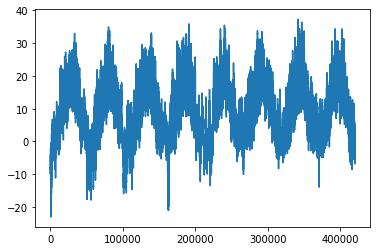

In [24]:
# 3.2 plot it. It is highly periodic
plt.plot(range(len(temp)), temp) ;
plt.show() ; 

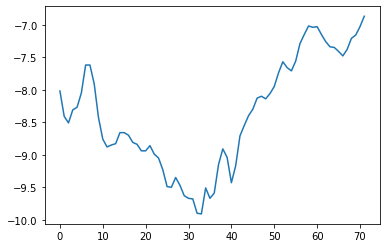

In [25]:
# 3.3 Let us see 12-hour variation
#     How many readings in one-day?  (24 * 60 )/10 = 144
#     So half day = 72 points
#     It is half of this variation we want to predict

plt.plot(range((12*60//10)), temp[:72]) ;
plt.show() ; 

In [26]:
# 3.4 Delete unwanted variable
del temp
gc.collect()

4882

## Standardize data

In [27]:
### Data pre-processing
###---------------
# 3.4 For processing we center and scale all data
#     Could have used sklearn's StandardScaler()
#     We decide upon a max sample size of 2 lakh
#     Were we rich in memory, more could have been selected

training_data_size = 420551     # select 200000 to save memory

In [28]:
# 3.4.1 Get column-wise (axis= 0) mean
#       We extract mean from training data only but would apply
#       to whole of data

mean = float_data[:training_data_size].mean(axis = 0)
mean[:4]     # Show means of Ist four column means


array([989.21277606,   9.45014735, 283.49274343,   4.95585384])

In [29]:
# 3.4.2 Subtract from each column, its respective mean
#       We subtract this from all data.

float_data = float_data - mean


In [30]:
# 3.4.3 Get std deviation of each column but from training data only
std = float_data[:training_data_size].std(axis = 0)
std[:4]    # First four column std deviation

array([8.35847079, 8.4233552 , 8.50446129, 6.73066631])

In [31]:
# 3.4.4 Divide each column by its respective std deviation
float_data /= std
float_data.shape

(420551, 14)

## Create data generators

In [ ]:
################## Learning to create data generators ###############
##################### Expt & explanation #############################
## 4.0 Problem defined:
## --------------------
## Starting from any point, say, i, in dataset, our intention is
##  to lookback 1440 timesteps (24*60/10=144/day; 10days) behind,  
##   and using this data, predict temp one day ahead of i ie 144 
##    time steps ahead of i.
##    Instead of considering all 1440 lookback points, we will sample
##     one point per hour or just 240 datapoints for 10 days (24 * 10)
##      at hourly interval. 
##


In [ ]:
## Train Data Generator
## ---------------------
## 4.1 Case 1: How will we generate our training data?
##  Pick any random index, i, and then we will generate 
##    our data. Let us randomly pick i as: 302:
##        Batch 1 (240 observations)
##                (14 attributes + target)
##    obs   pressure     temp    humidity        Target
##    302     0.87        0.1     0.23             0.17
##    303     0.28        0.91    0.77             0.63
##    304     0.56        0.33    0.99             0.45
##    305       ..           ..      ..
##           ..           ..      ..
##    541     0.86        0.09    0.13             0.21
##    last point: i + 240 -1

##  4.1.1 Per epoch, we will pick 128 random indices (i(s)) & then generate
##         128 batches of data (steps_per_epoch = 128). Our data generator
##          can generate infinite batches of data, epoch-after-epoch.
##

In [ ]:
##  4.1.2 We will have heve 128 batches of (each batch: 240 X 14) datasets. 
##        For training data, all our 128 batches will be picked up randomly
##        from first 2 lakh data points. We select some arbitrary points
##        (arbitrary Xs) within our data and proceed sequentially to pick up
#         240 rows.

In [ ]:
##  4.1.3 We will make random selection of 128 points many
##        times (infinitely) in our training-data-generator (steps_per_epoch).
##        This will help in changing the sequence of time steps.

In [ ]:
##  4.1.4 Here is exactly how a batch is created for training:
##        ------------------------------------------------------
##        Starting from any point between row 1440 (24 * 6 * 10 days) 
##        till last row that is 200000th row, we make some random selection
##        of 128 numbers. Say, one number is 20451. From this number we look back
##        at all the data 1440 timesteps behind that is we start from index of
##        20451 - 1440 -1  = 19010. And start picking up, every 6th point. 
##        This will make us available 1440/6 = 240 observations.
##        And we want to predict temperature 'delay' ahead. So our target
##        value for this 2D data will be temperature reading, at row: 20451 + delay.

In [ ]:
## 4.2 Validation data Generator
## -----------------------------
##  For validation data, we start with min_index = 200001 and keep max_index = 300000.
##  This time we will NOT pick up batches randomly but sequentially. We start with 
##   200001 + lookback = 200001+1440 = 2001441 and get 128 row-numbers 
##     (including 2001441) sequentially that is: 201441, 201442,...201568 
##       ie (200001 + 1440 +128 - 1). We take each of these
##      numbers and prepare dataset of 240 points (each point at an interval of 6steps)
##       Thus we have a first batch of 128.

In [ ]:
## 4.3 Test Data generator
##  ----------------------------------------------
#  Same as for validation but this time min_index = 300001 and max_index = None
#   that is upto: len(float_data) - delay - 1

## Constants

In [ ]:
# 4.4. Define some common constants
lookback = 1440  # timesteps. (same as 10 days) In RNN, we will lookback at
                 #            1440 timesteps. Each timestep is 10 minutes.
# 4.5
step = 6         # timesteps.  But we will pick temp values at every
                 # hour rather than ever 10 minutes that is pick one point after
                 #   every 6th point.
                 # So in this per lookback period datapoints will be 1440/6 = 240
                 # So during 1440 time-steps dataset size will be 240 X 14.
# 4.6
delay = 144      # timesteps. (same as 24 hours) We will forecast for a temperatue
                 # 144 timesteps ahead
# 4.7
batch_size = 128 # Analyse 'dataset' in batches of 128 considering memory limitations
                 # So we will analyse in memory at a time: 128 (samples) X 240 X 14

In [ ]:
#############################
###### Case 1   Training data generator
#############################

# Define constants specific to this Case that is training data
# 5.
min_index = 0        # For training, we start from here
max_index = 200000   # Our last point for training
shuffle = True       # Training batches will be picked up randomly

## Experiment

In [ ]:
##******************************************************
# 6. Begin creating batches of datasets--One batch only
##******************************************************

# 6.1 Our 'X' should be between min_index and max_index.
if max_index is None:    # None means no value is specified. We then calculate
                         # None is same as NULL in other languages
    max_index = len(float_data) - delay - 1   # 420406. Keep it just less than forecasting duration

# 6.1.1
max_index

200000

In [ ]:
# 6.2
i = min_index + lookback     # Begin here so that we can pick up earlier points
i


1440

In [ ]:
# 6.3
i      # 1440 timesteps to start with or 10 days lookback
       # If this is time, t, RNN gets data for t-1,
       #  t-2, right upto first point as lookback is 1440 timesteps
       # np.random.randint(low, high, howmany)
       # np.random.randint(0,100,10)   Gives 10 random points

In [ ]:
# 6.4
#--
if shuffle:               # shuffle = True for training only
    # Generate 128 random points (Xs) for picking training batches
    #   Try: np.random.randint(0, 100, size = 12)

    #                             1440              200000           128
    rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
else:                       # for validation and test datasets
    if i + batch_size >= max_index:   # Given some 'i', if it exceeds limit
        i = min_index + lookback      #  then set it to min possible
    # Try np.arange(1, min(1+10,14))
    rows = np.arange(i, min(i + batch_size, max_index))  # Get a list of all
                                                         #  points from i uptill the limit
    i += len(rows)      # Increment i by 128

In [ ]:
# 6.5 Have a look at rows from where to start picking up 240 lookback points
rows
print("\n=====\n")
min(rows)    # min index
print("\n=====\n")
max(rows)    # max index
print("\n=====\n")
len(rows)    # 128 points

In [ ]:
# 6.6 Given row-points, get samples of datasets, each of 240 X 14
#     Now get an array of zeros of requistie batch size:
# Try np.zeros((2,3,4))

#  3D array          128            240         14
samples = np.zeros((len(rows),lookback // step, float_data.shape[-1]))
samples = np.zeros((128,240,14))    # same as above
# 6.7 Check
samples.shape   # (128,240,14) (batch size, no_of_points_per_hour, attributes)


In [ ]:
# 6.8 There will be as many targets as there are batches
targets = np.zeros((len(rows),))
targets = np.zeros((128,))     # same as above
targets
print("\n==========\n")
len(targets)    # 128

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

128

In [ ]:
# 7. Prepare to fill in first batch into our 3D zero-array
j = 0                 # Later we can loop on this 'j'
row = rows[j]         # First random point
row

123335

In [ ]:
# 7.1 Whereever I am standing (say at, 1000), I go behind
#     'lookback' timesteps (say 100). From there, I proceed
#      forward, every 6-datapoints upto where I am standing
#       (ie upto 1000). So I collect 240 datapoints:
#        Try: indicies = list(range(1000-100, 1000, 6))

In [ ]:
#  7.2 Get indices of those 240 datapoints at intervals of 6 (step)
#      beginning from  jth index of rows[j]

indices = range(rows[j] - lookback, rows[j], step)   # 1440 timesteps values but in steps of 6
indices   # range(195492, 196932, 6)


In [ ]:
print("\n=========\n")
len(indices)      # total: 240 points
print("\n=========\n")
list(indices)     # What are the points. Spaced at interval of 6

In [ ]:
# 8. Finally, fill our zero-sample with data at these indicies
samples[j] = float_data[indices]          # 240 points
samples[j].shape                          # 240 X 14
print("\n========\n")
# 8.1 Just have a look
samples[j]

In [ ]:
# 8.2 Our prediction datapoint is 'delay' timesteps ahead
#     And in the data, temperature is at index 1
targets[j] = float_data[rows[j] + delay][1]   # Taregt value is the value in IInd column

# 8.3                                         #  at the end of rows[j] + delay
targets[j]

In [ ]:
#############################
###### Case 2   Validation data generator
#############################

In [ ]:
# 9. We will have min_index = 200001 and max_index = 300000 and shuffle = False
#    Other constants remain same:
min_index = 200001
max_index = 300000
shuffle = False

In [ ]:
# 9.1
if max_index is None:
    max_index = len(float_data) - delay - 1      # 420406

In [ ]:
# 9.2
i = min_index + lookback
i      # 201441

In [ ]:
# 9.3   We have to get 128 consecutive points from where to pickup
#       128 batches of 240 X 14
if shuffle:
    rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
else:
    # 9.3.1
    if i + batch_size >= max_index:  # If unable to get list of 128 points ahead
                                     #   to get 128 batches of (240 X 14)
        i = min_index + lookback     #  start afresh. min_index for validation is 200001
    # 9.3.2
    rows = np.arange(i, min(i + batch_size, max_index))  # Get a list of all
                                                         #  points from i uptill the limit
   # 9.3.3
    i += len(rows)                     # Advance i by 128 steps to get next 128 batches

In [ ]:
# 10
i              # Next batch begins at: 200001 + 1440 + 128 = 201569
print("\n===========\n")
len(rows)                    # 128
print("\n===========\n")
rows           # Just list them

In [ ]:
# 11. Get an array of batch-size of all zeros
# Now get
#                      128            240         14
samples = np.zeros((len(rows), lookback // step, float_data.shape[-1]))
samples.shape   # (128,240,14) (batch size, no_of_points_per_hour, attributes)

In [ ]:
# 11.1 There will be as many targets as there are batches
targets = np.zeros((len(rows),))
targets
len(targets)    # 128

In [ ]:
# 12. Fill the batch with data
row = rows[0]    # First data point to start first batch from
j = 0
row              # 201441

In [ ]:
# 12.1 Whereever I am standing, I go loopback back
#      From there, I proceed forward, every 6-datapoints
#      So I collect 240 datapoints
#  Get indices of those 240 datapoints

#                    200001          201441   6
indices = range(rows[j] - lookback, rows[j], step)   # 1440 timesteps values but in steps of 6
print("\n============\n")
indices   # rrange(200001, 201441, 6)
print("\n============\n")
len(indices)      # total: 240 points

In [ ]:
# 12.2
samples[j] = float_data[indices]          # 240 points
samples[j].shape                          # 240 X 14

In [ ]:
# 12.3
samples[j]

In [ ]:
# 13. Our prediction datapoint is delay timesteps ahead
targets[j] = float_data[rows[j] + delay][1]   # Taregt value is the value in IInd column
                                              #  at the end of rows[j] + delay
# 13.1
targets[0]

In [ ]:
# So finally return this sample and target
#   yield samples, targets

In [ ]:
#############################
###### Case 3   Test data generator
#############################

In [ ]:
# 14. Finally use all above to define a generator to generate data:
## Our generator:
#    def generator():
#        while True:
#
#          Get 128 points from where to pick up data
#		   		For training data:
#					Select 128 random points between (0+lookback, 200000)
#				For validation/test data:
#					Start counting from i = 200001 (valid) or 300001 (test)
#					Select next 128 consecutive pts from where we finished earlier
#					i = i +128
#
#		 	Now we have 128 points either for training data or for validation/test data
#				create zero-array of size 128 X 240 X 14
#		   		Fill each one of the 128 zero-arrays with, 240 X 14 values
#          		Get an array of 128 targets at 'delay' distance
#
#          	yield sample, target
#


In [ ]:
def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6):

    if max_index is None:       # Only for test data we do not set max_index
        max_index = len(data) - delay - 1

    # 14.1 min_index = (train)0, (valid)200001, (test)300001
    i = min_index + lookback

    while 1:
        if shuffle:         #14.2 True for train data, False for valid & test data
            rows = np.random.randint(min_index + lookback,    # lower limit, min_index = 0
                                     max_index,               # Upto here, max_index = 200000
                                     size=batch_size          # Select any 128 pts
                                     )
        else:              #14.3 For validation generator rows are between (200001, 207201)
            if i + batch_size >= max_index:
                i = min_index + lookback
            #14.4 Starting i is 'min_index + lookback'
            rows = np.arange(i, min(i + batch_size, max_index))   # No random rows picking
                                                                  # Normal length of 'rows'
																  #  is batch_size or less

            #14.5 Value of this 'i' will be preserved between calls to generator()
            i += len(rows)   # Next i for valid and test is 128 distance away

        # 14.1 Create empty sample (128 X 240 X 14)
        #                      128            240         14
        samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
        # 14.2 Create 128 empty targets
        targets = np.zeros((len(rows),))

        # 14.3 For every one of the 128 points...
        for j, row in enumerate(rows):
            # 14.4 Set read-pointer to 'lookback' behind
            #      from this rows[j] and pick next 240 points
            #      at intervals of 6 points
            indices = range(rows[j] - lookback,  rows[j], step)
            # 14.5 Get data into our sample
            samples[j] = data[indices]
            # 14.6 Get targets (temperature: IINd columns).
            #      index [1] => IInd column or temperatue column
            targets[j] = data[rows[j] + delay][1]
        # 14.7 Return objects per call
        yield samples, targets


In [ ]:
# 15. Our common constants
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [ ]:
# 16. train data generator
train_gen = generator(float_data,
                       lookback=lookback,
                       delay=delay,
                       min_index=0,
                       max_index=200000,
                       shuffle=True,
                       step=step,
                       batch_size=batch_size)

In [ ]:
# 16.1 Have a look. Run for-loop twice to see change.
for samples, targets in train_gen:
    print(targets[0])
    print(samples[0])
    print(samples[0].shape)
    break

In [ ]:
# 16.2
a = train_gen

# 16.2.1 Get first set of dataset
s = next(a)
type(s)            # Tuple
s[0].shape         # (128,240,1)
s[1].shape         # (128,)

# 16.2.2 Get next set of dataset
t = next(a)
t[0].shape
t[1].shape


In [ ]:
# 17. Validation data generator
val_gen = generator(
                   float_data,
                   lookback=lookback,
                   delay=delay,
                   min_index=200001,
                   max_index= 300000,              # 207201, 300000, 200001 + 1440 *5
                   step=step,
                   batch_size=batch_size
                   )


In [ ]:
# 18. Test data generator
test_gen = generator(
                     float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [ ]:
# 19 How many times to draw from validation generator
#    in order to see all validation data
val_steps = (300000 - 200001 - lookback)    # Instead of 300000-200001 - lookback to save time
val_steps        # 98559
# At the end of each epoch, validation follows.
# These many validation steps, take a long time
# for epoch to complete. As time is important
# to us, we will limit val_steps to 400, so:
# 19.1
val_steps = 400

In [ ]:
# 20
test_steps = (len(float_data) - 300001 - lookback)
test_steps


In [ ]:
####################################################
## 21. We will work with:
#              i) Fully connected model
#             ii) GRU model
#            iii) GRU model with dropouts
#             iv) Stacked GRU models

In [ ]:
# This is from the book:
def generator(data,lookback,delay,min_index,max_index,shuffle=False,batch_size=128,step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros(
                            (
                              len(rows),
                              lookback // step,
                              data.shape[-1]
                              )
                             )
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets